In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Library import
import pandas as pd
import os
import re
import tensorflow as tf
import pandas as pd
import os
import re
import cv2
import albumentations as alb
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import VGG19, ResNet152V2, InceptionResNetV2, MobileNetV3Large
from tensorflow.keras.layers import AveragePooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from functools import partial
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import VGG16
from functools import partial
from sklearn.model_selection import train_test_split

# Constant Variables:
_auto_tune = tf.data.experimental.AUTOTUNE
_batch_size = 32

_image_width_original = 512
_image_height_original = 512
_image_size = [_image_width_original, _image_height_original]

_image_resize_width = 224
_image_resize_height = 224
_image_resize = [_image_resize_width, _image_resize_height]
print('Model input shape {} x {}.'.format(_image_resize_width, _image_resize_height))

_channels = 3
_n_class = 5
_n_repeat = 4
_img_norm = 255.0

_classes = [str(x) for x in range(_n_class)]
_major_label = 3
_classes_names = ['Cassava Bacterial Blight',
                  'Cassava Brown Streak Disease',
                  'Cassava Green Mottle',
                  'Cassava Mosaic Disease',
                  'Healthy']
_train_file = '/content/drive/MyDrive/cassava-leaf-disease-classification/'
_train_recs = list(filter(lambda x: '.tfrec' in x, os.listdir(_train_file)))
_epochs = 20
_valid_size = 0.1
_train_df = pd.read_csv('/content/drive/MyDrive/cassava-leaf-disease-classification/train.csv', encoding='utf_8_sig',
                        engine='python')
_file_label_map = dict(zip(_train_df.image_id.tolist(), _train_df.label.astype(int).tolist()))
_random_corp_size = [_image_resize_width, _image_resize_height, _channels]


# Decoding single image:
def decode_img(img,
               n_channels: int = _channels,
               img_size: list = None,
               img_norm: float = _img_norm):
    if img_size is None:
        img_size = _image_size
    img = tf.image.decode_jpeg(img, channels=n_channels)
    img = tf.reshape(img, [*img_size, n_channels])
    return img


# Parsing the files
def parse_img(x,
              n_class: int = _n_class):
    feature_description = {'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
                           'target': tf.io.FixedLenFeature([], tf.int64, default_value=-1)}
    parsed_features = tf.io.parse_single_example(x, feature_description)
    img = decode_img(parsed_features['image'])
    label = tf.one_hot(parsed_features['target'], depth=n_class)
    return img, label


# Load data
def load_img(files: list,
             ordered=False):
    df = tf.data.TFRecordDataset(files)
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    df = df.with_options(ignore_order)
    df = df.map(parse_img)
    return df


# Train-validation split
_train_fn, _valid_fn = \
    train_test_split(tf.io.gfile.glob(_train_file + 'ld_train*.tfrec'),
                     test_size=_valid_size,
                     random_state=5,
                     shuffle=True)

Model input shape 224 x 224.


In [3]:

# Function for getting the training data set
def get_train_data(train_fn: list = _train_fn,
                   batch_size: int = _batch_size):
    df = load_img(train_fn)
    df = df.repeat().shuffle(2048).batch(batch_size).prefetch(_auto_tune)
    return df


# Function for getting the validation data set
def get_valid_data(valid_fn: list = _valid_fn,
                   batch_size: int = _batch_size):
    df = load_img(valid_fn)
    df = df.batch(batch_size).cache().prefetch(_auto_tune)
    return df


# Reporting the size of training, validation and testing data
def report_data_size(train_f=_train_fn,
                     valid_f=_valid_fn):
    def count_file(x):
        return sum([int(re.compile(r"-([0-9]*)\.").search(i).group(1)) for i in x])

    n_train, n_valid= count_file(train_f), count_file(valid_f)
    print('Train Images: {} | Validation Images: {}'.format(n_train, n_valid))
    return n_train, n_valid


# Check the size of the data
_n_train, _n_valid = report_data_size()

# Fetching training, validation and testing data
train_data = get_train_data()
valid_data = get_valid_data()

print("Train Data Size {} | Validation Data Size {}".format(train_data._flat_shapes, valid_data._flat_shapes))

Train Images: 18721 | Validation Images: 2676
Train Data Size [TensorShape([None, 512, 512, 3]), TensorShape([None, 5])] | Validation Data Size [TensorShape([None, 512, 512, 3]), TensorShape([None, 5])]


In [4]:
input_module = tf.keras.layers.Input(shape=(*_image_size, _channels))
flip_module = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')
roration_module = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.4, 0.4))
crop_module = tf.keras.layers.experimental.preprocessing.RandomCrop(height=_image_resize_height, width=_image_resize_width)
rand_height_module = tf.keras.layers.experimental.preprocessing.RandomHeight(factor=0.25)
rand_width_module = tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.25)
contrast_module = tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.3)
rescale_module = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1/255)
zoom_module = tf.keras.layers.experimental.preprocessing.RandomZoom(0.5, 0.3)

In [5]:
def load_model():
    base = MobileNetV3Large(
        weights='imagenet',
        include_top=False,
        input_shape=(_image_resize_height, _image_resize_width, 3)
    )
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(5,
              activation='softmax')(x)
    m = Model(inputs=base.input, outputs=x)
    return m

In [14]:
_opt = tf.keras.optimizers.Adam(lr=1e-05)
_loss = CategoricalCrossentropy(label_smoothing=0.05)
_epochs = 20
_finetune_epochs = 10

model_ver_4 = load_model()

In [15]:
model = tf.keras.Sequential([input_module, 
                             flip_module,
                             roration_module,
                             crop_module,
                             rand_height_module,
                             rand_width_module,
                             contrast_module,
                             zoom_module,
                             rescale_module,
                             model_ver_4])

In [16]:
model.compile(
        optimizer=_opt,
        loss=_loss,
        metrics=['categorical_accuracy']
    )

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 512, 512, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 512, 512, 3)       0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_height (RandomHeight) (None, None, 224, 3)      0         
_________________________________________________________________
random_width (RandomWidth)   (None, None, None, 3)     0         
_________________________________________________________________
random_contrast (RandomContr (None, None, None, 3)     0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, None, None, 3)    

In [18]:
_es = EarlyStopping(monitor='val_loss',
                    mode='min',
                    patience=10)
_r = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.8,
                       patience=2,
                       verbose=1,
                       mode='auto',
                       epsilon=0.0001,
                       cooldown=5,
                       min_lr=0.00001)

_callback = [_es, _r]

history = model.fit(train_data, validation_data=valid_data, epochs=_epochs, callbacks=_callback, steps_per_epoch=_n_train//_batch_size)
model.save('/content/drive/MyDrive/cassava-leaf-disease-classification/MobileNetV3Large_ver_1_1.h5')
import pickle
with open('/content/drive/MyDrive/cassava-leaf-disease-classification/MobileNetV3_ver_1_1_hist.pkl', 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/20
585/585 [==============================] - 225s 330ms/step - loss: 1.3500 - categorical_accuracy: 0.5255 - val_loss: 1.5081 - val_categorical_accuracy: 0.0987
Epoch 2/20
585/585 [==============================] - 140s 239ms/step - loss: 0.9959 - categorical_accuracy: 0.6713 - val_loss: 1.4862 - val_categorical_accuracy: 0.1001
Epoch 3/20
585/585 [==============================] - 131s 223ms/step - loss: 0.9270 - categorical_accuracy: 0.6960 - val_loss: 1.6584 - val_categorical_accuracy: 0.1024
Epoch 4/20
585/585 [==============================] - 123s 210ms/step - loss: 0.8867 - categorical_accuracy: 0.7114 - val_loss: 2.1914 - val_categorical_accuracy: 0.1282
Epoch 5/20
585/585 [==============================] - 116s 199ms/step - loss: 0.8655 - categorical_accuracy: 0.7183 - val_loss: 2.7822 - val_categorical_accuracy: 0.1259
Epoch 6/20
585/585 [==============================] - 117s 200ms/step - loss: 0.8251 - categorical_accuracy: 0.7402 - val_loss: 2.7876 - val_categoric

In [19]:
for i in model_ver_4.layers:
    i.trainable = True
    if 'bn' in i.name:
        i.trainable = False

history2 = model.fit(train_data, validation_data=valid_data, epochs=30, callbacks=_callback, steps_per_epoch=_n_train//_batch_size)
model.save('/content/drive/MyDrive/cassava-leaf-disease-classification/MobileNetV3Large_ver_1_1_cp2.h5')

Epoch 1/30
585/585 [==============================] - 107s 172ms/step - loss: 0.7003 - categorical_accuracy: 0.7952 - val_loss: 0.7377 - val_categorical_accuracy: 0.7859
Epoch 2/30
585/585 [==============================] - 99s 170ms/step - loss: 0.6932 - categorical_accuracy: 0.8021 - val_loss: 0.7225 - val_categorical_accuracy: 0.8001
Epoch 3/30
585/585 [==============================] - 100s 171ms/step - loss: 0.7005 - categorical_accuracy: 0.7949 - val_loss: 0.7031 - val_categorical_accuracy: 0.8049
Epoch 4/30
585/585 [==============================] - 98s 168ms/step - loss: 0.6941 - categorical_accuracy: 0.7998 - val_loss: 0.7237 - val_categorical_accuracy: 0.7889
Epoch 5/30
585/585 [==============================] - 100s 171ms/step - loss: 0.6867 - categorical_accuracy: 0.8040 - val_loss: 0.7160 - val_categorical_accuracy: 0.7967
Epoch 6/30
585/585 [==============================] - 97s 166ms/step - loss: 0.6919 - categorical_accuracy: 0.8002 - val_loss: 0.7264 - val_categorical_

In [20]:
history3 = model.fit(train_data, validation_data=valid_data, epochs=20, callbacks=_callback, steps_per_epoch=_n_train//_batch_size)
model.save('/content/drive/MyDrive/cassava-leaf-disease-classification/MobileNetV3Large_ver_1_1_cp3.h5')

Epoch 1/20
585/585 [==============================] - 105s 167ms/step - loss: 0.6291 - categorical_accuracy: 0.8267 - val_loss: 0.6497 - val_categorical_accuracy: 0.8199
Epoch 2/20
585/585 [==============================] - 97s 165ms/step - loss: 0.6365 - categorical_accuracy: 0.8234 - val_loss: 0.6371 - val_categorical_accuracy: 0.8281
Epoch 3/20
585/585 [==============================] - 97s 166ms/step - loss: 0.6361 - categorical_accuracy: 0.8247 - val_loss: 0.6463 - val_categorical_accuracy: 0.8221
Epoch 4/20
585/585 [==============================] - 97s 166ms/step - loss: 0.6360 - categorical_accuracy: 0.8243 - val_loss: 0.6568 - val_categorical_accuracy: 0.8184
Epoch 5/20
585/585 [==============================] - 96s 164ms/step - loss: 0.6288 - categorical_accuracy: 0.8255 - val_loss: 0.6355 - val_categorical_accuracy: 0.8270
Epoch 6/20
585/585 [==============================] - 97s 166ms/step - loss: 0.6308 - categorical_accuracy: 0.8247 - val_loss: 0.6560 - val_categorical_ac

In [22]:
history4 = model.fit(train_data, validation_data=valid_data, epochs=20, callbacks=_callback, steps_per_epoch=_n_train//_batch_size)
model.save('/content/drive/MyDrive/cassava-leaf-disease-classification/MobileNetV3Large_ver_1_1_cp4.h5')

Epoch 1/20
585/585 [==============================] - 104s 165ms/step - loss: 0.6119 - categorical_accuracy: 0.8351 - val_loss: 0.6196 - val_categorical_accuracy: 0.8326
Epoch 2/20
585/585 [==============================] - 96s 165ms/step - loss: 0.6127 - categorical_accuracy: 0.8325 - val_loss: 0.6174 - val_categorical_accuracy: 0.8352
Epoch 3/20
585/585 [==============================] - 97s 166ms/step - loss: 0.6093 - categorical_accuracy: 0.8349 - val_loss: 0.6134 - val_categorical_accuracy: 0.8359
Epoch 4/20
585/585 [==============================] - 98s 167ms/step - loss: 0.6078 - categorical_accuracy: 0.8396 - val_loss: 0.6188 - val_categorical_accuracy: 0.8348
Epoch 5/20
585/585 [==============================] - 98s 167ms/step - loss: 0.6045 - categorical_accuracy: 0.8376 - val_loss: 0.6189 - val_categorical_accuracy: 0.8348
Epoch 6/20
585/585 [==============================] - 98s 167ms/step - loss: 0.6057 - categorical_accuracy: 0.8370 - val_loss: 0.6120 - val_categorical_ac

In [23]:
with open('/content/drive/MyDrive/cassava-leaf-disease-classification/MobileNetV3_ver_1_1_cp2.pkl', 'wb') as f:
    pickle.dump(history2.history, f, pickle.HIGHEST_PROTOCOL)
with open('/content/drive/MyDrive/cassava-leaf-disease-classification/MobileNetV3_ver_1_1_cp3.pkl', 'wb') as f:
    pickle.dump(history3.history, f, pickle.HIGHEST_PROTOCOL)
with open('/content/drive/MyDrive/cassava-leaf-disease-classification/MobileNetV3_ver_1_1_cp4.pkl', 'wb') as f:
    pickle.dump(history4.history, f, pickle.HIGHEST_PROTOCOL)

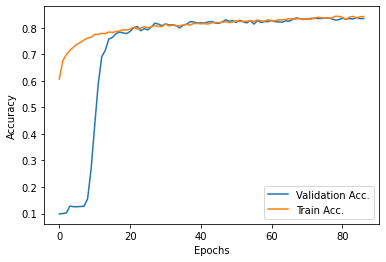

In [25]:
plt.plot(history.history['val_categorical_accuracy'] + 
         history2.history['val_categorical_accuracy'] + 
         history3.history['val_categorical_accuracy']  + 
         history4.history['val_categorical_accuracy'], label='Validation Acc.')
plt.plot(history.history['categorical_accuracy'] + 
         history2.history['categorical_accuracy'] + 
         history3.history['categorical_accuracy'] + 
         history4.history['categorical_accuracy'], label='Train Acc.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

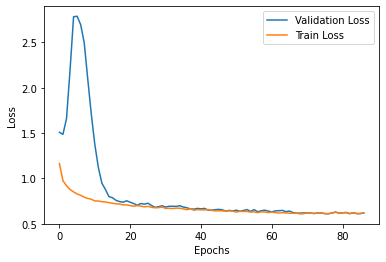

In [26]:
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['val_loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()